In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os

# Chargement de la base Sentiment140 préprocessée 

In [2]:
STOP_WORDS = True
LEMMATIZATION = True
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))

In [3]:
df = df.sample(50000, random_state=1234)
df.sentiment = df.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,@PcShakur I guess so. We should go make it a f...
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,@PsychicSophie Thank you!
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it's just another day here at the office...I a...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,@triciasays i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,@AmandaFClark Thats rubbish!
...,...,...,...,...,...,...
46422,Negative,1677402582,Sat May 02 01:53:46 PDT 2009,NO_QUERY,kmac1984,wondering what the hell is gonna happen next??...
34170,Negative,1564728728,Mon Apr 20 04:42:44 PDT 2009,NO_QUERY,engers,@jkoxvold Me too
888464,Positive,1687307615,Sun May 03 08:20:39 PDT 2009,NO_QUERY,_Alectrona_,I'm off Will maybe tweet later...Bye!
292279,Negative,1995953530,Mon Jun 01 14:18:18 PDT 2009,NO_QUERY,TraceyyMartinn,stomach hurts and i desperatly want to go sho...


# Count Vectorizer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.001)


X = df.text.to_list()
Y = df.sentiment.to_list()

X_vec = vectorizer.fit_transform(X).toarray()

In [5]:
X_train, X_test, y_train, y_test  = train_test_split(
        X_vec, 
        Y,
        train_size=0.80,
        random_state=1234)

In [6]:
def conf_matrix(y_pred, y_test, model):
    sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
    sc_f1 = sklearn.metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = sklearn.metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = sklearn.metrics.precision_score(y_pred, y_test, pos_label="Positive")

    sklearn.metrics.plot_confusion_matrix(model, X_test, y_test)
    plt.show()

    print(f"Accuracy : {sc_accuracy}")
    print(f"Recall : {sc_recall}")
    print(f"Precision : {sc_precision}")
    print(f"F1 : {sc_f1}")

# Gaussian Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

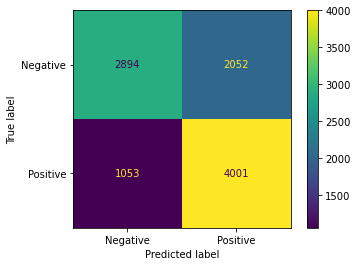

Accuracy : 0.6895
Recall : 0.6609945481579382
Precision : 0.7916501780767708
F1 : 0.7204465652291347


In [8]:
conf_matrix(y_pred, y_test, gauss)

In [9]:
# Fit to data and predict using pipelined scaling, GNB.
gauss = make_pipeline(StandardScaler(), GaussianNB())
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

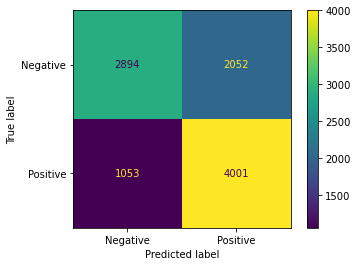

Accuracy : 0.6895
Recall : 0.6609945481579382
Precision : 0.7916501780767708
F1 : 0.7204465652291347


In [10]:
conf_matrix(y_pred, y_test, gauss)

# Naive Bayes using TD IDF

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [12]:
#Création du TD IDF Vectorizer
vectorizer2 = TfidfVectorizer(min_df=0.001)
vectorizer2.fit_transform(df.text)

<50000x1150 sparse matrix of type '<class 'numpy.float64'>'
	with 449589 stored elements in Compressed Sparse Row format>

In [13]:
X_vec2 = vectorizer2.fit_transform(X).toarray()

X_train2, X_test2, y_train2, y_test2  = train_test_split(
        X_vec2, 
        Y,
        train_size=0.80,
        random_state=1234)

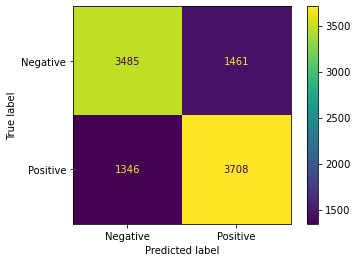

Accuracy : 0.7024
Recall : 0.6844815340909091
Precision : 0.7627621685793431
F1 : 0.7215047725996632


In [14]:
#Utilisation du GaussianNB
gauss = GaussianNB()
gauss.fit(X_train2, y_train2)
y_pred2_gauss = gauss.predict(X_test2)
conf_matrix(y_pred2_gauss, y_test2, gauss)

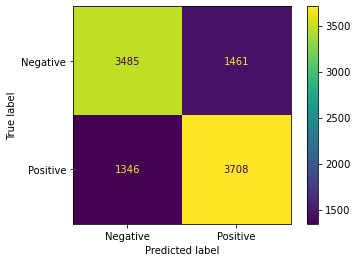

Accuracy : 0.7446
Recall : 0.7567789646672145
Precision : 0.7289275821131777
F1 : 0.7425922193106229


In [15]:
#Utilisation du MultinomialNB
multi = MultinomialNB(alpha=1) #par défaut alpha=1 : Laplace smoothing parameter
multi.fit(X_train2, y_train2)
y_pred2_multi = multi.predict(X_test2)
conf_matrix(y_pred2_multi,y_test2, gauss)

# Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())])

parameters = {'vect__max_features' : [None, 500, 1000, 2000, 5000],
          'tfidf__use_idf': [True, False],
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1],
}

grid_clf = GridSearchCV(text_clf, parameters, scoring = 'balanced_accuracy', cv=5)
_ = grid_clf.fit(X, Y)

grid_clf.best_params_

{'clf__alpha': 1, 'tfidf__use_idf': False, 'vect__max_features': 5000}